In [1]:
#!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
#import scipy as sp
#import scipy.optimize
import pandas as pd
#import neural_tangents as nt
import functools
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from jax import random, config
from jax.example_libraries import optimizers
from jax import grad, jit, vmap, lax

#from jax.api import jit, grad, vmap
#from neural_tangents import stax

#from google.colab import drive
#drive.mount('/content/gdrive')
#root_dir ='/content/gdrive/My Drive/dmft_res_sweep/'
root_dir = 'alt_results/'

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import jax
jax.devices()

gpu


[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0)]

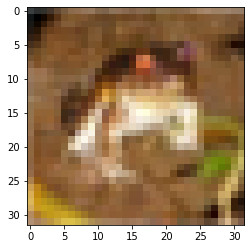

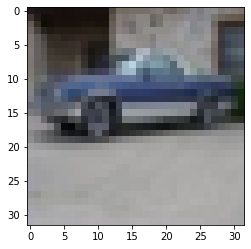

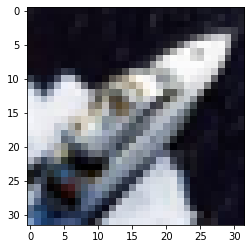

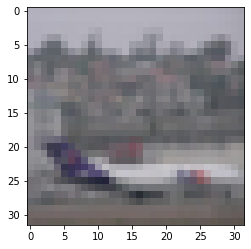

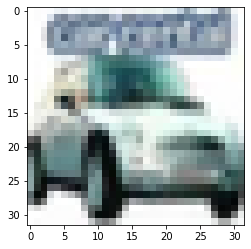

ind
10000
(10000, 32, 32, 3)
(2000, 32, 32, 3)


In [3]:
#import tensorflow as tf
#import tensorflow_datasets as tfds

"""
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], 
                               as_supervised = False, 
                               batch_size = -1)
train_images = tfds.as_numpy(train_ds)
X = train_images['image'] 
y = train_images['label']
test_images = tfds.as_numpy(test_ds)
X_test = test_images['image'] 
y_test = test_images['label']
"""



def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar_data():
    root_dir = '../cifar10/cifar-10-batches-py/'
    X = np.zeros((10000,32,32,3))
    #X_test = np.zeros((P_test,32,32,1))
    y = np.zeros(10000)
    #y_test = np.zeros(P_test)
    ind = 0
    for i in range(5):
        data_dict= unpickle(root_dir + 'data_batch_%d' % (i+1))
        X_all = data_dict[b'data']
        label = np.array(data_dict[b'labels'])
        inds01 = (label < 2)
        y_i = label[inds01]*2.0 - 1
        X_rgb = X_all.reshape((X_all.shape[0], 3,32,32)).transpose((0,2,3,1))/255.0
        plt.imshow(X_rgb[0])
        plt.show()
        #X_gray = 0.2989 * X_rgb[:,:,:,0] + 0.5870 * X_rgb[:,:,:,1] + 0.1140 * X_rgb[:,:,:,2]
        X_gray = X_rgb[inds01]
        X[ind:ind+X_gray.shape[0],:,:,:] = X_gray
        y[ind:ind+y_i.shape[0]] = y_i
        ind = ind + X_gray.shape[0]
    print("ind")
    print(ind)
    data_dict = unpickle(root_dir + 'test_batch')
    X_all = np.array(data_dict[b'data'])
    X_rgb = X_all.reshape((X_all.shape[0], 3,32,32)).transpose((0,2,3,1)) / 255.0
    #X_gray = 0.2989 * X_rgb[:,:,:,0] + 0.5870 * X_rgb[:,:,:,1] + 0.1140 * X_rgb[:,:,:,2]
    label_test = np.array(data_dict[b'labels'])
    inds01 = (label_test < 2)
    X_test = X_rgb[inds01,:,:,:]
    X_test = X_test.reshape((X_test.shape[0],32,32,3))
    y_test = np.array(label_test)[inds01] * 2.0 - 1.0
    
    """
    X[0:P//2,:,:,0] = X_gray[inds0,:,:][0:P//2]
    X[P//2:,:,:,0] = X_gray[inds1,:,:][0:P//2]
    y = np.zeros(P)
    y[0:P//2] = 2*label[inds0][0:P//2]-1.0
    y[P//2:] = 2*label[inds1][0:P//2]-1.0
    
    X_test[0:P_test//2,:,:,0] = X_gray[inds0,:,:][P//2:P//2+P_test//2]
    X_test[P_test//2:,:,:,0] = X_gray[inds1,:,:][P//2:P//2+P_test//2]
    y_test = np.zeros(P_test)
    y_test[0:P_test//2] = 2*label[inds0][P//2:P//2+P_test//2]-1.0
    y_test[P_test//2:] = 2*label[inds1][P//2:P//2+P_test//2]-1.0
    """
    
    return X, y, X_test, y_test


X, y, X_test, y_test = load_cifar_data()

np.save(root_dir + 'y_first_600.npy', y[0:600])

print(X.shape)
print(X_test.shape)
#X_test, y_test = load_cifar_data(1000)



In [4]:
img = X[0:12]
kernel = jnp.zeros((3,3,3,3))
kernel += jnp.einsum('ij,kl->ijkl', jnp.eye(3),jnp.eye(3))
#kernel += jnp.eye(3)[:,:,jnp.newaxis,jnp.newaxis]
dn = lax.conv_dimension_numbers(img.shape,     # only ndim matters, not shape
                                kernel.shape,  # only ndim matters, not shape 
                                ('NHWC', 'HWIO', 'NHWC'))  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))


out shape:  (12, 32, 32, 3)
First output channel:


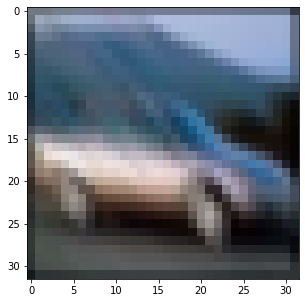

In [5]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,1),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(5,5))
plt.imshow(np.array(out)[0,:,:,:] / jnp.amax(out));


In [34]:
nonlin_fn = lambda h: (h>0.0) * h
def cnn(params,X):
    L = len(params)-1
    N = params[0].shape[-1]
    h = lax.conv_general_dilated(X, params[0],(1,1),'SAME', (1,1),(1,1),dn)
    phi = nonlin_fn(h)
    for i in range(1,L-1):
        h = 1/jnp.sqrt(N) * lax.conv_general_dilated(phi, params[i], (1,1),'SAME', (1,1),(1,1),dn)
        phi = nonlin_fn(h)
    phi = phi.mean(axis = (1,2)) # phi is N x H x W x C
    w = params[-1]
    f = 1/N * phi @ w
    return f

def get_cnn_features(params,X):
    L = len(params)-1
    N = params[0].shape[-1]
    h = lax.conv_general_dilated(X, params[0],(1,1),'SAME', (1,1),(1,1),dn)
    phi = nonlin_fn(h)
    for i in range(1,L-1):
        h = 1/jnp.sqrt(N) * lax.conv_general_dilated(phi, params[i], (1,1),'SAME', (1,1),(1,1),dn)
        phi = nonlin_fn(h)
    phi = phi.mean(axis = (1,2)) # phi is N x H x W x C
    w = params[-1]
    f = 1/N * phi @ w
    return phi

def initialize_cnn(L, N, seed=0):
    key = random.PRNGKey(seed)
    params = []
    params += [ random.normal(key, (3,3,3,N)) ]
    for l in range(L-1):
        key,_ = random.split(key)
        params += [random.normal(key, (3,3,N,N))]
    params += [random.normal(key, (N,))]
    return params


def train_model(L , N, batch = 250, T = 5000, eta=2.0e-4, gamma=0.5):
    params0 = initialize_cnn(L,N)
    opt_init, opt_update, get_params = optimizers.sgd(eta * gamma**2 * N)
    opt_state = opt_init(params0)
    loss_fn = lambda params, X, y: jnp.mean( ( 1/gamma*(cnn(params,X)-cnn(params0,X)) -y)**2 )
    grad_fn = lambda params, X, y: grad(loss_fn)(params, X, y)
    align_fn = lambda K, y: jnp.dot(y, K @ y) / jnp.sum(y**2) / jnp.sqrt(jnp.sum(K**2))
    acc_fn = lambda params, X, y: jnp.mean( (1/gamma*(cnn(params,X)-cnn(params0,X)) * y)>0.0 )
    num_batch = int(X.shape[0]/ batch)
    test_losses = []
    test_accs = []
    Phi_aligns = []
    for t in range(T):
        bt = t % num_batch
        Xt = X[bt:bt+batch]
        yt = y[bt:bt+batch]
        opt_state = opt_update(t, grad_fn(get_params(opt_state), Xt, yt), opt_state)
        if t % 50 == 0:
            test_losses += [np.array(loss_fn(get_params(opt_state),X_test, y_test))]
            test_accs += [np.array(acc_fn(get_params(opt_state), X_test, y_test))]
            phi = get_cnn_features(get_params(opt_state), X_test[0:250])
            Phi = phi @ phi.T / N
            A = align_fn(Phi,y_test[0:250])
            Phi_aligns += [np.array(A)]
            sys.stdout.write('\r t %d | test loss: %0.4f | test acc: %0.4f | A = %0.6f' % (t, test_losses[-1],test_accs[-1], A))
    return test_losses, test_accs, Phi_aligns

L = 4
Nvals = [250, 500]
gamma_vals = [1.0,5.0,10.0]
all_losses = []
all_aligns = []
all_accs = []
for i, N in enumerate(Nvals):
    losses_i = []
    aligns_i = []
    accs_i = []
    for j, gamma in enumerate(gamma_vals):
        print(" ")
        print("N = %d | gamma = %0.2f" % (N, gamma))
        losses, accs, aligns = train_model(L, N, gamma=gamma)
        losses_i += [losses]
        accs_i += [accs]
        aligns_i += [aligns]
    
    all_losses += [losses_i]
    all_aligns += [aligns_i]
    all_accs += [accs_i]



 
N = 250 | gamma = 1.00
 t 4950 | test loss: 0.6743 | test acc: 0.7645 | A = 0.023742 
N = 250 | gamma = 5.00
 t 4950 | test loss: 0.5518 | test acc: 0.8195 | A = 0.031138 
N = 250 | gamma = 10.00
 t 4950 | test loss: 0.5527 | test acc: 0.8190 | A = 0.059002 
N = 500 | gamma = 1.00
 t 4950 | test loss: 0.6587 | test acc: 0.7740 | A = 0.024257 
N = 500 | gamma = 5.00
 t 4950 | test loss: 0.5497 | test acc: 0.8220 | A = 0.031935 
N = 500 | gamma = 10.00
 t 4950 | test loss: 0.5506 | test acc: 0.8205 | A = 0.060801

In [35]:

save_dir = 'scratch_results/'
np.save(save_dir + 'all_losses.npy', all_losses)
np.save(save_dir + 'all_accs.npy', all_accs)
np.save(save_dir + 'all_aligns.npy', all_aligns)


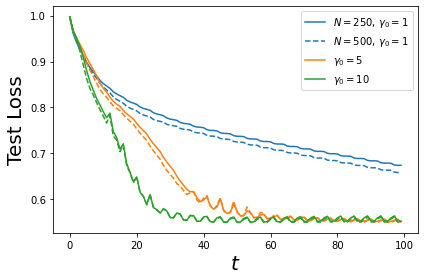

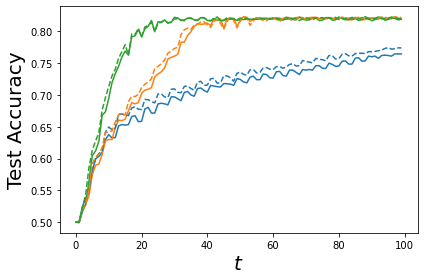

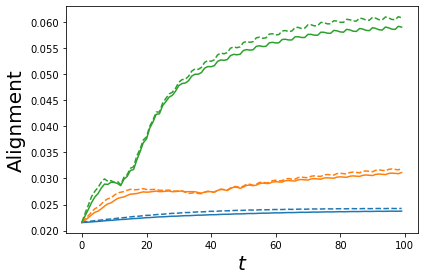

In [36]:
for j, gamma in enumerate(gamma_vals):
    for i, N in enumerate(Nvals):
        if i == 0:
            ls = '-'
        else:
            ls = '--'
        if j == 0:
            plt.plot(all_losses[i][j], ls, color = 'C%d' % j, label = r'$N = %d$, $\gamma_0 = %d$' % (N,gamma))
        elif i == 0:
            plt.plot(all_losses[i][j], ls, color = 'C%d' % j, label = r'$\gamma_0 = %d$' % gamma)
        else:
            plt.plot(all_losses[i][j], ls, color = 'C%d' % j)

plt.legend()
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.tight_layout()
plt.savefig(save_dir + 'all_test_losses.pdf')
plt.show()

for i, N in enumerate(Nvals):
    if i == 0:
        ls = '-'
    else:
        ls = '--'
    for j, gamma in enumerate(gamma_vals):
        plt.plot(all_accs[i][j], ls, color = 'C%d' % j)

plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'Test Accuracy',fontsize = 20)
plt.tight_layout()
plt.savefig(save_dir + 'all_test_accs.pdf')
plt.show()


for i, N in enumerate(Nvals):
    if i == 0:
        ls = '-'
    else:
        ls = '--'
    for j, gamma in enumerate(gamma_vals):
        plt.plot(all_aligns[i][j], ls, color = 'C%d'%j)
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'Alignment',fontsize = 20)
plt.tight_layout()
plt.savefig(save_dir + 'all_aligns.pdf')
plt.show()